In [5]:
from datetime import datetime
import numpy as np
import os
os.environ['MPLCONFIGDIR'] = "/wrk-vakka/users/hajaalin/tmp_mplconfigdir"
from matplotlib import pyplot as plt
%matplotlib inline
from pathlib import Path
import shap
import sys

from etl_tsc import load_data
from utility import parse_config

paths = "/proj/hajaalin/Projects/n_track_ML/scripts/tsc/paths.yml"
paths = parse_config(paths)
    
# add InceptionTime source to Python path
src_inceptiontime = paths["src"]["inceptiontime"]
sys.path.insert(1, src_inceptiontime)
from cv_inceptiontime import inceptiontime_cv_repeat, get_standard_scaling, apply_standard_scaling
from utils.utils import readucr

# read the data 
data_dir = paths["data"]["dir"]
raw_data_file = paths["data"]["raw_data_file"]
fset = "all"
X, y, groups, features, datam, datan = load_data(Path(data_dir) / raw_data_file, fset, debug=True)





/proj/group/lmu/software/Miniconda3/py38_4.12.0/envs/tsc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


sklearn 1.1.1
sktime 0.10.1
Loaded data shape: (8398, 17)
Index(['file', 'serum', 'D', 'A', 'P', 'Dist', 't', 'dt'], dtype='object')
X.shape: (289, 6, 28)
X.shape: (289, 28, 6)


# InceptionTime input example
Check the input format based on test data (https://github.com/hfawaz/InceptionTime#data). 

The order is (instance, timestep, feature).

In [6]:
file_name = \
'/proj/hajaalin/Projects/UCR_TS_Archive_2015/InlineSkate/InlineSkate_TRAIN'
print('test_ucr: ' + file_name)
x_train, y_train = readucr(file_name)
print('x_train.shape: ' + str(x_train.shape))
print('y_train.shape: ' + str(y_train.shape))
# https://github.com/hajaalin/InceptionTime/blob/d518ebe04c4404e49bdb056aa4aa00ea6ba9bd26/main.py#L35
if len(x_train.shape) == 2:  # if univariate
    # add a dimension to make it multivariate with one dimension
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print('x_train.shape: ' + str(x_train.shape))


test_ucr: /proj/hajaalin/Projects/UCR_TS_Archive_2015/InlineSkate/InlineSkate_TRAIN
x_train.shape: (100, 1882)
y_train.shape: (100,)
x_train.shape: (100, 1882, 1)


# Check data loading intermediates
## Multi-index dataframe

In [7]:
datam.head()

file  \
fp                                       frame                                          
210521_guide_1514i.sld_-_1514_i10_t35__0 2      210521_guide_1514i.sld_-_1514_i10_t35   
                                         3      210521_guide_1514i.sld_-_1514_i10_t35   
                                         4      210521_guide_1514i.sld_-_1514_i10_t35   
                                         5      210521_guide_1514i.sld_-_1514_i10_t35   
                                         6      210521_guide_1514i.sld_-_1514_i10_t35   

                                                serum         D           A  \
fp                                       frame                                
210521_guide_1514i.sld_-_1514_i10_t35__0 2          0  0.117854  301.848958   
                                         3          0  0.366152  301.458175   
                                         4          0  0.239324  300.937131   
                                         5          0  0.187754  301.492454   
                                         6          0  0.094312  301.979219   

                                                        P      Dist         t  \
fp                                       frame                                  
210521_guide_1514i.sld_-_1514_i10_t35__0 2      18.558761  1.773953  3.131322   
                                         3      18.709589  1.343691 -1.903313   
                                         4      18.634175  1.526075  0.431272   
                                         5      18.538193  1.435976 -3.092591   
                                         6      18.565617  1.441959 -0.843499   

                                                      dt  
fp                                       frame            
210521_guide_1514i.sld_-_1514_i10_t35__0 2      1.233874  
                                         3     -5.034635  
                                         4      2.334585  
                                         5     -3.523863  
                                         6      2.249091

## Nested dataframe

In [8]:
datan.head()

,file,serum,D,A,P,Dist,t,dt
0,2 210521_guide_1514i.sld_-_1514_i10_t35 3 ...,2 0 3 0 4 0 5 0 6 0 7 ...,2 0.117854 3 0.366152 4 0.239324 5...,2 301.848958 3 301.458175 4 300.93...,2 18.558761 3 18.709589 4 18.63417...,2 1.773953 3 1.343691 4 1.526075 5...,2 3.131322 3 -1.903313 4 0.431272 5...,2 1.233874 3 -5.034635 4 2.334585 5...
1,2 210521_guide_1514i.sld_-_1514_i10_t35 3 ...,2 0 3 0 4 0 5 0 6 0 7 ...,2 0.216666 3 0.094942 4 0.111515 5...,2 301.848958 3 301.458175 4 300.93...,2 18.558761 3 18.709589 4 18.63417...,2 4.449394 3 4.513221 4 4.391940 5...,2 2.197163 3 1.830648 4 -1.163123 5...,2 3.695569 3 -0.366515 4 -2.993771 5...
2,2 210521_guide_1514i.sld_-_1514_i1_t0 3 ...,2 1 3 1 4 1 5 1 6 1 7 ...,2 0.178829 3 0.157572 4 0.192724 5...,2 512.165585 3 512.384972 4 511.99...,2 19.573425 3 19.498011 4 19.52543...,2 8.067957 3 8.165918 4 7.983479 5...,2 0.297310 3 2.660113 4 0.903404 5...,2 -2.646482 3 2.362802 4 -1.756709 5...
3,2 210521_guide_1514i.sld_-_1514_i1_t0 3 ...,2 1 3 1 4 1 5 1 6 1 7 ...,2 0.047684 3 0.064591 4 0.193787 5...,2 512.165585 3 512.384972 4 511.99...,2 19.573425 3 19.498011 4 19.52543...,2 7.585871 3 7.720695 4 7.894178 5...,2 1.016186 3 -0.930621 4 -2.030110 5...,2 3.653593 3 -1.946807 4 -1.099489 5...
4,2 210521_guide_1514i.sld_-_1514_i2_t0_ 3 ...,2 1 3 1 4 1 5 1 6 1 7 ...,2 0.128653 3 0.008553 4 0.026992 5...,2 278.881891 3 278.792765 4 278.29...,2 14.781193 3 14.788049 4 14.76748...,2 1.855279 3 1.882042 4 1.883155 5...,2 1.932570 3 -0.246117 4 1.314753 5...,2 3.544357 3 -2.178687 4 1.560871 5...


## Numpy array
Check that order is (instance, timestep, feature) as in the example above.

(289, 28, 6)
[[1.17853868e-01 3.01848958e+02 1.85587610e+01]
 [3.66152200e-01 3.01458175e+02 1.87095895e+01]
 [2.39324351e-01 3.00937131e+02 1.86341752e+01]
 [1.87753582e-01 3.01492454e+02 1.85381935e+01]
 [9.43115227e-02 3.01979219e+02 1.85656168e+01]
 [2.95413433e-01 3.02054633e+02 1.86136077e+01]
 [5.30514119e-01 3.01746120e+02 1.86410311e+01]
 [3.18407073e-01 3.01794111e+02 1.86958778e+01]
 [2.64851734e-01 3.01979219e+02 1.87370128e+01]
 [3.83052910e-01 3.02219173e+02 1.86890220e+01]
 [9.66055800e-02 3.01218220e+02 1.86478869e+01]
 [7.67474198e-02 3.01773544e+02 1.87027336e+01]
 [2.52588090e-01 3.01636427e+02 1.86615986e+01]
 [5.79309723e-02 3.01382761e+02 1.86204636e+01]
 [2.79227669e-01 3.01595292e+02 1.86547428e+01]
 [4.05124575e-01 3.01163374e+02 1.85998960e+01]
 [4.86220811e-01 3.01423896e+02 1.86547428e+01]
 [1.49985643e-01 3.01547301e+02 1.86890220e+01]
 [1.87615541e-01 3.01307346e+02 1.86547428e+01]
 [1.39931581e-01 3.01513022e+02 1.86341752e+01]
 [2.54295206e-01 3.01094815

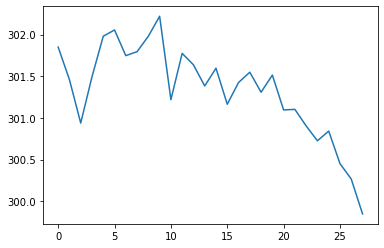

In [44]:
print(X.shape)
print(X[0,:,0:3])
print(list_shap_deep[0].shape)
plt.plot(X[0,:,1])


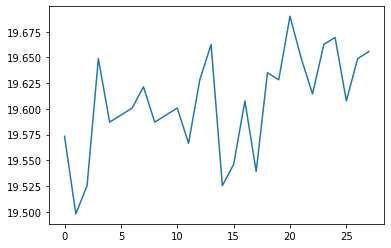

In [43]:
%matplotlib inline
plt.plot(X[2,:,2])


## Class array

In [11]:
print(y.shape)
print(y[0:5])

(289,)
[0. 0. 1. 1. 1.]


In [12]:
np.concatenate((y,), axis=0)[0:5]

array([0., 0., 1., 1., 1.])

In [13]:
y.reshape(-1,1)[0:5]

array([[0.],
       [0.],
       [1.],
       [1.],
       [1.]])

## Class array onehot encoded
Note that ```yoh[1]``` corresponds to the original class array. SHAP values will be computed for both model inputs, the ones corresponding to the original class labels will be in index ```[1]```-

In [14]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(np.concatenate((y,), axis=0).reshape(-1, 1))
yoh = enc.transform(y.reshape(-1, 1)).toarray()
print(yoh[0:5])

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# Test scaling

get_standard_scaling
(289, 28, 6)
(6,)
(6,)
[ 6.86663121e-02  3.57286334e+02  1.72903288e+01  3.42911147e+00
 -1.78580657e-04 -2.26079082e-03]
apply_standard_scaling
(289, 28, 6)
(6,)
(6,)
(289, 28, 6)
[[ 0.87180386 -0.38415371  0.3424533 ]
 [ 5.27266177 -0.38686164  0.38317421]
 [ 3.02475564 -0.39047222  0.36281376]
 [ 2.11071153 -0.38662411  0.33690045]
 [ 0.4545376  -0.38325107  0.34430425]
 [ 4.01888266 -0.38272848  0.3572609 ]
 [ 8.18582453 -0.38486633  0.36466471]
 [ 4.42642364 -0.38453377  0.37947231]
 [ 3.47720486 -0.38325107  0.39057801]
 [ 5.5722112  -0.3815883   0.37762136]
 [ 0.49519764 -0.38852441  0.36651566]
 [ 0.14323015 -0.38467629  0.38132326]
 [ 3.25984313 -0.38562645  0.37021756]
 [-0.19027395 -0.38738423  0.35911186]
 [ 3.73200499 -0.38591149  0.36836661]
 [ 5.96341101 -0.38890447  0.353559  ]
 [ 7.40076668 -0.38709918  0.36836661]
 [ 1.4413098  -0.38624405  0.37762136]
 [ 2.10826489 -0.38790681  0.36836661]
 [ 1.26311088 -0.38648158  0.36281376]
 [ 3.29010018 -0.3

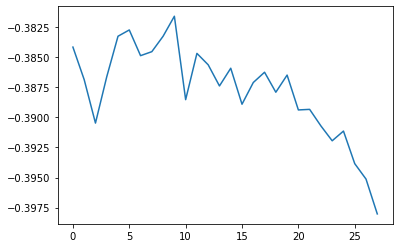

In [45]:
mean, std = get_standard_scaling(X)
print(mean)
X_scaled = apply_standard_scaling(X, mean, std)
print(X_scaled[0,:,0:3])
print(list_shap_deep[0].shape)
plt.plot(X_scaled[0,:,1])

(74, 28, 6)


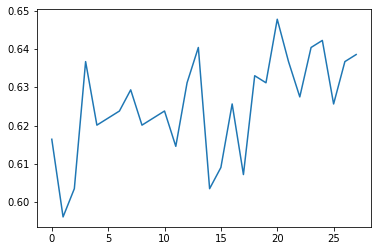

In [47]:
print(list_shap_deep[0].shape)
plt.plot(X_scaled[2,:,2])


# Repeat cross-validation with InceptionTime

In [18]:
# parameters
use_bottleneck=True
kernel_size = 20
epochs = 20
repeats = 2
job_name = "shap_inceptiontime"
job_id = "1"
now = datetime.now().strftime("%Y%m%d%H%M%S")
save_shap_values = True
set_split_random_state = False
verbose = True

# output folders
output_shap = Path(paths["output"]["shap"]) / job_name / now
output_shap.mkdir(parents=True, exist_ok=True)
output_it = Path(paths["output"]["it"]) / job_id
output_it.mkdir(parents=True, exist_ok=True)
output_it = str(output_it) + "/"

print(output_shap)
!ls $output_shap
os.listdir(output_shap)

/wrk/group/lmu/projects/n_track_ML/output/shap/shap_inceptiontime/20221207112125


[]

In [19]:
repeat_output = inceptiontime_cv_repeat(X, y, groups, features, output_it, fset, \
                                        use_bottleneck=use_bottleneck, \
                                        kernel_size=kernel_size, \
                                        epochs=epochs, \
                                        repeats=repeats, \
                                        job_id=job_id, \
                                        save_shap_values=save_shap_values, \
                                        verbose=verbose)
scores, shap_lists_all = repeat_output


Index(['D', 'A', 'P', 'Dist', 't', 'dt'], dtype='object')
input_shape
(28, 6)
StratifiedGroupKFold(n_splits=4, random_state=None, shuffle=True)
repeat: 1/2
get_standard_scaling
(215, 28, 6)
(6,)
(6,)
apply_standard_scaling
(215, 28, 6)
(6,)
(6,)
(215, 28, 6)
check scaled shape
(215, 28, 6)
(215, 28, 6)


2022-12-07 11:22:34.571233: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 6)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 28, 32)       192         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 28, 6)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 28, 32)       3072        ['conv1d[0][0]']                 
                                                                                              

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


get_standard_scaling
(218, 28, 6)
(6,)
(6,)
apply_standard_scaling
(218, 28, 6)
(6,)
(6,)
(218, 28, 6)
check scaled shape
(218, 28, 6)
(218, 28, 6)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 6)]      0           []                               
                                                                                                  
 conv1d_44 (Conv1D)             (None, 28, 32)       192         ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_6 (MaxPooling1D)  (None, 28, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_45 (Conv1D)             (None, 28, 

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


get_standard_scaling
(223, 28, 6)
(6,)
(6,)
apply_standard_scaling
(223, 28, 6)
(6,)
(6,)
(223, 28, 6)
check scaled shape
(223, 28, 6)
(223, 28, 6)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 6)]      0           []                               
                                                                                                  
 conv1d_88 (Conv1D)             (None, 28, 32)       192         ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_12 (MaxPooling1D  (None, 28, 6)       0           ['input_3[0][0]']                
 )                                                                                                
                                           

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


get_standard_scaling
(211, 28, 6)
(6,)
(6,)
apply_standard_scaling
(211, 28, 6)
(6,)
(6,)
(211, 28, 6)
check scaled shape
(211, 28, 6)
(211, 28, 6)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 6)]      0           []                               
                                                                                                  
 conv1d_132 (Conv1D)            (None, 28, 32)       192         ['input_4[0][0]']                
                                                                                                  
 max_pooling1d_18 (MaxPooling1D  (None, 28, 6)       0           ['input_4[0][0]']                
 )                                                                                                
                                           

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


len(list_shap_deep):4
len(list_shap_grad):4
StratifiedGroupKFold(n_splits=4, random_state=None, shuffle=True)
repeat: 2/2
get_standard_scaling
(218, 28, 6)
(6,)
(6,)
apply_standard_scaling
(218, 28, 6)
(6,)
(6,)
(218, 28, 6)
check scaled shape
(218, 28, 6)
(218, 28, 6)
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 6)]      0           []                               
                                                                                                  
 conv1d_176 (Conv1D)            (None, 28, 32)       192         ['input_5[0][0]']                
                                                                                                  
 max_pooling1d_24 (MaxPooling1D  (None, 28, 6)       0           ['input_5[0][0]']                
 )                  

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


get_standard_scaling
(218, 28, 6)
(6,)
(6,)
apply_standard_scaling
(218, 28, 6)
(6,)
(6,)
(218, 28, 6)
check scaled shape
(218, 28, 6)
(218, 28, 6)
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 6)]      0           []                               
                                                                                                  
 conv1d_220 (Conv1D)            (None, 28, 32)       192         ['input_6[0][0]']                
                                                                                                  
 max_pooling1d_30 (MaxPooling1D  (None, 28, 6)       0           ['input_6[0][0]']                
 )                                                                                                
                                          

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


get_standard_scaling
(216, 28, 6)
(6,)
(6,)
apply_standard_scaling
(216, 28, 6)
(6,)
(6,)
(216, 28, 6)
check scaled shape
(216, 28, 6)
(216, 28, 6)
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 6)]      0           []                               
                                                                                                  
 conv1d_264 (Conv1D)            (None, 28, 32)       192         ['input_7[0][0]']                
                                                                                                  
 max_pooling1d_36 (MaxPooling1D  (None, 28, 6)       0           ['input_7[0][0]']                
 )                                                                                                
                                          

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


get_standard_scaling
(215, 28, 6)
(6,)
(6,)
apply_standard_scaling
(215, 28, 6)
(6,)
(6,)
(215, 28, 6)
check scaled shape
(215, 28, 6)
(215, 28, 6)
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 6)]      0           []                               
                                                                                                  
 conv1d_308 (Conv1D)            (None, 28, 32)       192         ['input_8[0][0]']                
                                                                                                  
 max_pooling1d_42 (MaxPooling1D  (None, 28, 6)       0           ['input_8[0][0]']                
 )                                                                                                
                                          

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


len(list_shap_deep):8
len(list_shap_grad):8


In [20]:
scores

,accuracy,precision,recall,f1,repeat,cv,classifier,fset,kernel_size,epochs,job_id
0,0.567568,0.777778,0.446809,0.567568,1.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1
1,0.577465,0.558824,0.558824,0.558824,1.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1
2,0.575758,0.480000,0.444444,0.461538,1.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1
3,0.538462,0.571429,0.800000,0.666667,1.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1
4,0.563380,0.652174,0.394737,0.491803,2.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1
5,0.563380,0.500000,1.000000,0.666667,2.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1
6,0.534247,0.705882,0.292683,0.413793,2.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1
7,0.635135,0.653846,0.790698,0.715789,2.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1


In [21]:
print(scores.accuracy.mean())

0.5694242180471198


# Save and load SHAP values

In [25]:
from cv_inceptiontime import shap2npy

shap2npy(fset, shap_lists_all, output_shap)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [26]:
!ls $output_shap

features.npy	 list_accuracy.npy  list_idx_train.npy	list_shap_grad.npy
list_X_test.npy  list_idx_test.npy  list_shap_deep.npy


In [27]:
import os 
os.listdir(output_shap)

['list_idx_train.npy',
 'list_X_test.npy',
 'list_idx_test.npy',
 'list_shap_deep.npy',
 'list_accuracy.npy',
 'list_shap_grad.npy',
 'features.npy']

In [30]:
list_idx_train = np.load(output_shap / 'list_idx_train.npy', allow_pickle=True)
list_idx_test = np.load(output_shap / 'list_idx_test.npy', allow_pickle=True)
list_X_test = np.load(output_shap / 'list_X_test.npy', allow_pickle=True)
list_shap_deep = np.load(output_shap / 'list_shap_deep.npy', allow_pickle=True)
list_shap_grad = np.load(output_shap / 'list_shap_grad.npy', allow_pickle=True)
list_accuracy = np.load(output_shap / 'list_accuracy.npy', allow_pickle=True)
features_load = np.load(output_shap / 'features.npy', allow_pickle=True)

In [41]:
print(list_accuracy.mean())
print(list_idx_train.shape)
print(list_idx_train[0].shape)
print(list_idx_train[0])
print(list_idx_test[0])
print(list_shap_deep.shape)
print(list_shap_deep[0].shape)
print(list_shap_grad[0].shape)
print(list_shap_deep[0][0])


0.5694242180471198
(8,)
(215,)
[  2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  20  21  24
  25  26  27  28  29  32  33  34  35  36  37  38  39  40  41  44  45  48
  49  52  53  54  55  56  57  60  61  62  63  64  65  68  69  70  71  72
  73  74  75  76  77  80  81  82  83  84  85  88  89  90  91  92  93  94
  95  96  97 100 101 102 103 106 107 108 109 110 111 112 113 114 115 120
 121 122 123 124 125 126 129 130 131 132 133 134 135 136 137 138 141 142
 143 144 145 146 147 148 151 152 153 154 157 158 159 160 161 162 165 166
 167 170 171 172 173 174 175 176 177 180 181 182 183 186 187 188 189 190
 191 194 195 196 197 198 201 202 203 204 207 208 211 212 213 214 215 216
 221 222 223 224 225 226 228 230 231 232 233 234 235 237 239 240 241 242
 243 245 247 248 249 250 252 254 256 257 258 259 260 262 264 265 266 267
 268 269 270 272 274 275 276 278 280 281 282 283 284 285 286 287 288]
[  0   1  13  18  19  22  23  30  31  42  43  46  47  50  51  58  59  66
  67  78  79  86  87  9

# Class distribution

In [16]:
print(y[y==0].shape)
print(y[y==1].shape)



(136,)
(153,)


In [17]:
np.save(output_shap / 'y_mean.npy', y)

In [18]:
y_max = np.load('/wrk-vakka/group/lmu/projects/n_track_ML/output/shap/shap_inceptiontime/20221117135226/y_max.npy')
y_mean = np.load('/wrk-vakka/group/lmu/projects/n_track_ML/output/shap/shap_inceptiontime/20221117140251/y_mean.npy')


In [19]:
np.sum(y_max - y_mean)

0

In [20]:
y_max - y_mean

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [21]:
y_max


array([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1])

In [22]:
y_mean

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1])